# Detecting Gender Bias in English-German Translations using Natural Language Processing

This notebook presents the bias detection model used for the demonstration. **Minimal documentation and interpretation are provided, as it is intended to be read alongside the thesis.**  

The notebook performs the following steps:  
1. Reads the created dataset.  
2. Loads and trains a multilingual BERT model.  
3. Evaluates the model on the held-out dataset and the handcrafted dataset.

**Disclaimer:** All results reported in this notebook were obtained using Python 3.12 on a CPU. Do note that results may differ if the notebook is run with other Python versions or on a GPU.  

## Import Libraries
Standard Python libraries are imported for data handling, computation, and plotting. PyTorch and the Transformers library are used for model training and inference. Evaluation metrics and dataset splitting functions are imported from scikit-learn.  

In [1]:
# standard libraries
import os
import random

# data handling
import pandas as pd
import numpy as np

# torch and dataset utils
import torch
from torch.utils.data import Dataset

# transformers library
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

# evaluation and data split
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
)
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

/Users/khali/Documents/GitHub/bias-detector-en-de-1/thesis-env-3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set Seed
A fixed seed is set for Python, NumPy, and PyTorch random number generators. This ensures that results are reproducible across runs. CUDA deterministic settings are enabled to maintain consistent GPU computations.  


In [2]:
seed = 10

def set_seed(seed):
    random.seed(seed)                  
    np.random.seed(seed)              
    torch.manual_seed(seed)           
    torch.cuda.manual_seed(seed)      
    torch.cuda.manual_seed_all(seed)   
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(seed)

## Load Dataset
The dataset is loaded from a CSV file. This dataset was created using the `join_datasets.py` script located in the `/datasets` directory. It contains sentence pairs with labels indicating whether the translation exhibits gender bias. The first few rows are displayed for inspection.

In [3]:
df = pd.read_csv("datasets/dataset.csv")
df.head(5)

,english,german,label
0,The student representatives are responsible.,die Schülervertreter*innen sind verantwortlich.,0
1,"I also call upon the Ministers, Heads of State...",Ebenso appelliere ich an die Minister sowie an...,1
2,The deputies are responsible.,Die Stellvertreterinnen sind verantwortlich.,1
3,"I do not know whether, as one of the speakers ...","Ich weiß nicht, ob ich wie zuvor gesagt wurde,...",0
4,The reader is responsible.,Die Leserin ist verantwortlich.,1


# Initialize Model

The computational device is determined, prioritizing GPU if available. Device information is printed to confirm the configuration.


In [4]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# print device info
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU: None (using CPU)")

CUDA Available: False
GPU: None (using CPU)


## Load Tokenizer
The tokenizer corresponding to the selected mBERT model is loaded. This tokenizer is used to convert input text into the token IDs required by the model.


In [5]:
# model name
model_path = "bert-base-multilingual-cased"

# load tokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)

## Load Model and Send to Device
The pre-trained mBERT model is loaded with a sequence classification head configured for binary classification. The model is transferred to the previously selected device for training and evaluation.


In [6]:
# load model with classification head
model = BertForSequenceClassification.from_pretrained(
    model_path,
    num_labels=2,
    id2label={0: "neutral", 1: "biased"},
    label2id={"neutral": 0, "biased": 1}
)

# move model to device
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

## Freeze Encoder Layers Count Trainable Parameters
The first eight encoder layers (layers 0 to 7) of BERT are frozen to reduce training time while allowing higher layers to adapt to the task. Freezing fewer layers increases trainable parameters and flexibility, which was tested in additional experiments.

In [7]:
# freeze encoder layers 0 to 7
for name, param in model.named_parameters():
    if name.startswith("bert.encoder.layer."):
        layer_num = int(name.split(".")[3])
        if layer_num < 8:
            param.requires_grad = False

# count and print trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable params: {trainable_params}")

Trainable params: 121152002


# Data Pre-processing
The EN-DE dataset is prepared for training, validation, and testing. Minimal preprocessing is applied, as the data has already been cleaned and labeled for bias detection.

## Custom Dataset Class
A custom `BiasDataset` class is defined to handle EN-DE sentence pairs. Each sample is tokenized using the mBERT tokenizer, with the German translation provided as the `text_pair`. The label tensor is included for supervised training.

In [8]:
# custom dataset for bias detection
class BiasDataset(Dataset):
    # init with dataframe and tokenizer
    def __init__(self, dataframe, tokenizer):
        self.data = dataframe
        self.tokenizer = tokenizer

    # return number of samples
    def __len__(self):
        return len(self.data)

    # return one encoded sample
    def __getitem__(self, idx):
        english = self.data.iloc[idx]["english"]
        german = self.data.iloc[idx]["german"]
        label = int(self.data.iloc[idx]["label"])

        # tokenize EN-DE sentence pair
        encoded = self.tokenizer(
            text=english,
            text_pair=german,
            padding="max_length",
            truncation=True,
            max_length=256,
            return_tensors="pt"
        )

        # encoded outputs have extra batch dimension, remove it with squeeze(0) to get plain tensors
        item = {key: val.squeeze(0) for key, val in encoded.items()}
        # add label tensor to the dict under key 'labels'
        item["labels"] = torch.tensor(label)
        return item


## Train Test Split
The dataset is split into train (80%), validation (10%), and test (10%) sets. Stratified sampling is applied to maintain the label distribution across all splits.

In [9]:
# split data into train (80%) and temp (20%), keeping label distribution same with stratify
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=seed
)

# split temp into validation (10%) and test (10%) sets, stratified by label
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["label"],
    random_state=seed
)


## Create Dataset Objects
`BiasDataset` objects are created for the train, validation, and test sets. These objects provide tokenized EN-DE sentence pairs and labels to the model during training and evaluation.

In [10]:
# create train, validation and test datasets
train_dataset = BiasDataset(train_df, tokenizer)  
val_dataset = BiasDataset(val_df, tokenizer)    
test_dataset = BiasDataset(test_df, tokenizer)  

# Training
The mBERT model is trained on the EN-DE bias dataset. The training procedure follows the hyperparameters and setup described below.

## Training Parameters
Hyperparameters are defined for learning rate, batch size, number of epochs, and output directory. TrainingArguments are configured to perform evaluation, logging, and model saving at the end of each epoch. The best model is loaded automatically based on macro F1 score.


In [11]:
# hyperparameters
lr = 2e-5
batch_size = 16
num_epochs = 8

output_dir="./model_output"

training_args = TrainingArguments(
    seed = seed,
    output_dir=output_dir,       
    num_train_epochs=num_epochs,   
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size,   
    learning_rate=lr,             
    warmup_ratio=0.1,
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",       
    load_best_model_at_end=True,  
    metric_for_best_model="eval_f1_macro",  
    greater_is_better=True   
)

## Evaluation Metrics Calculation for Classification
A custom metric function is defined to calculate precision, recall, F1 score, and support for each class. Macro averages and overall accuracy are also computed to allow consistent evaluation across training and validation datasets.

In [12]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=1)

    precision, recall, f1, support = precision_recall_fscore_support(
        labels, predictions, average=None, zero_division=0
    )

    metrics = {
        # per-class
        **{f"precision_class_{i}": precision[i] for i in range(len(precision))},
        **{f"recall_class_{i}":    recall[i]    for i in range(len(recall))},
        **{f"f1_class_{i}":        f1[i]        for i in range(len(f1))},
        **{f"support_class_{i}":   support[i]   for i in range(len(support))},
        # overall
        "precision_macro": np.mean(precision),
        "recall_macro":    np.mean(recall),
        "f1_macro":        np.mean(f1),
        "accuracy":        (predictions == labels).mean(),
    }

    return metrics

## Run trainer
A `Trainer` object is instantiated with the model, datasets, training arguments, metric function, and early stopping callback. Training is executed with exception handling. After completion, the trained model and tokenizer are saved to the specified output directory.

In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [14]:
print("Starting training...")

try:
    train_results = trainer.train()
except Exception as e:
    print("Training failed:", e)
    raise

print("Training complete. Saving model...")

trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

Starting training...


/Users/khali/Documents/GitHub/bias-detector-en-de-1/thesis-env-3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Precision Class 0,Precision Class 1,Recall Class 0,Recall Class 1,F1 Class 0,F1 Class 1,Support Class 0,Support Class 1,Precision Macro,Recall Macro,F1 Macro,Accuracy
1,0.545000,0.367436,0.909677,0.800000,0.805714,0.906667,0.854545,0.850000,175,150,0.854839,0.856190,0.852273,0.852308
2,0.272900,0.167946,0.969136,0.889571,0.897143,0.966667,0.931751,0.926518,175,150,0.929353,0.931905,0.929134,0.929231
3,0.109900,0.147580,0.950276,0.979167,0.982857,0.940000,0.966292,0.959184,175,150,0.964721,0.961429,0.962738,0.963077
4,0.061400,0.147034,0.988304,0.961039,0.965714,0.986667,0.976879,0.973684,175,150,0.974672,0.976190,0.975281,0.975385
5,0.050900,0.141204,0.988304,0.961039,0.965714,0.986667,0.976879,0.973684,175,150,0.974672,0.976190,0.975281,0.975385
6,0.031600,0.173657,0.960227,0.959732,0.965714,0.953333,0.962963,0.956522,175,150,0.959979,0.959524,0.959742,0.960000


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
/Users/khali/Documents/GitHub/bias-detector-en-de-1/thesis-env-3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not retur

Training complete. Saving model...


('./model_output/tokenizer_config.json',
 './model_output/special_tokens_map.json',
 './model_output/vocab.txt',
 './model_output/added_tokens.json')

Training stopped early because the validation F1-macro did not improve after epoch 6. The best model was selected based on the highest F1-macro score, which reached 0.9753.
 

# Evaluate
The trained mBERT model is evaluated on the validation and test sets. Both overall performance metrics and detailed error analyses are computed.


## Evaluation Metrics and Confusion Rates

A function is defined to compute confusion matrix components and false positive/negative rates. The `evaluate_and_print` function performs evaluation on a given dataset, prints the macro F1 score, confusion matrix, error rates, and a detailed classification report.


In [15]:
def compute_rates(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fp_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    fn_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
    return tn, fp, fn, tp, fp_rate, fn_rate

def evaluate_and_print(trainer, dataset, name):
    print(f"\nEvaluating on {name} set...")

    # Evaluate with compute_metrics
    results = trainer.evaluate(eval_dataset=dataset)
    print(f"{name} F1:", round(results["eval_f1_macro"], 3))

    # Get raw predictions and labels
    output = trainer.predict(dataset)
    logits = output.predictions
    labels = output.label_ids
    preds = np.argmax(logits, axis=1)

    # Confusion matrix breakdown
    tn, fp, fn, tp, fp_rate, fn_rate = compute_rates(labels, preds)
    print(f"{name} Confusion Matrix:")
    print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
    print(f"False Positive Rate={fp_rate:.3f}, False Negative Rate={fn_rate:.3f}")

    # Classification report
    print(f"\n{name} Classification Report:\n",
          classification_report(labels, preds, zero_division=0, digits=4))

    return output  # Optional, in case you want to reuse preds later

# ---- Main Evaluation ----
print("Evaluating model...")

val_output  = evaluate_and_print(trainer, val_dataset,  "Validation")
test_output = evaluate_and_print(trainer, test_dataset, "Test")


Evaluating model...

Evaluating on Validation set...


/Users/khali/Documents/GitHub/bias-detector-en-de-1/thesis-env-3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation F1: 0.975


/Users/khali/Documents/GitHub/bias-detector-en-de-1/thesis-env-3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation Confusion Matrix:
TN=169, FP=6, FN=2, TP=148
False Positive Rate=0.034, False Negative Rate=0.013

Validation Classification Report:
               precision    recall  f1-score   support

           0     0.9883    0.9657    0.9769       175
           1     0.9610    0.9867    0.9737       150

    accuracy                         0.9754       325
   macro avg     0.9747    0.9762    0.9753       325
weighted avg     0.9757    0.9754    0.9754       325


Evaluating on Test set...


/Users/khali/Documents/GitHub/bias-detector-en-de-1/thesis-env-3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test F1: 0.966


/Users/khali/Documents/GitHub/bias-detector-en-de-1/thesis-env-3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test Confusion Matrix:
TN=165, FP=10, FN=1, TP=149
False Positive Rate=0.057, False Negative Rate=0.007

Test Classification Report:
               precision    recall  f1-score   support

           0     0.9940    0.9429    0.9677       175
           1     0.9371    0.9933    0.9644       150

    accuracy                         0.9662       325
   macro avg     0.9655    0.9681    0.9661       325
weighted avg     0.9677    0.9662    0.9662       325



## Detailed Error Analysis

Predictions on the test set are combined with the corresponding EN-DE sentence pairs and true labels. False positives and false negatives are identified to allow inspection of model errors.

In [16]:
test_texts_en = test_dataset.data["english"].tolist()
test_texts_de = test_dataset.data["german"].tolist()

test_labels = test_output.label_ids
test_preds  = np.argmax(test_output.predictions, axis=1)

analysis_df = pd.DataFrame({
    "text_en":    test_texts_en,
    "text_de":    test_texts_de,
    "true_label": test_labels,
    "pred_label": test_preds
})

fp_df = analysis_df[(analysis_df.true_label == 0) & (analysis_df.pred_label == 1)]
fn_df = analysis_df[(analysis_df.true_label == 1) & (analysis_df.pred_label == 0)]

In [17]:
pd.set_option('display.max_colwidth', None)

combined_df = pd.concat([
    fp_df.assign(Error='False Positive'),
    fn_df.assign(Error='False Negative')
], ignore_index=True)[['Error', 'text_en', 'text_de']]

combined_df.columns = ['Error Type', 'English Text', 'German Text']

display(combined_df)


,Error Type,English Text,German Text
0,False Positive,"Accordingly, the President of the French Republic, the President of the European Council and the French Prime Minister asked me to visit, before the President of the French Republic, the ten countries which are currently asking for only one commissioner.","In diesem Sinne haben das Oberhaupt der Republik, die Präsidentschaft des Europäischen Rates und das französische Regierungsoberhaupt mich beauftragt, vor der Rundreise des Oberhaupts der Republik die zehn Länder aufzusuchen, die gegenwärtig nur einen Kommissionssitz beanspruchen."
1,False Positive,"In so doing, we are beginning to train the next generation of police officers to work and operate throughout Europe; in other words, we will be preparing them to implement Community law and joint and Community actions.","Wir beginnen also jetzt mit der Ausbildung der nächsten Generation von Polizeibeamteten, die in der Lage sein sollen, auf europäischer Ebene zu arbeiten und zu handeln, d. h. sie werden darauf vorbereitet, das Gemeinschaftsrecht anzuwenden und die gemeinsamen und gemeinschaftlichen Maßnahmen umzusetzen."
2,False Positive,"The Heads of State and Government therefore agreed a number of measures to promote the development of risk capital in the European Union, with a deadline for implementing the Risk Capital Action Plan of 2003.","Die Staats - und Regierungoberhäupter beschlossen deshalb eine Reihe von Maßnahmen zur Förderung der Entwicklung von Risikokapital in der Europäischen Union, um den Risikokapital - Aktionsplan bis zum Jahr 2003 vollständig umzusetzen."
3,False Positive,"We will, over the coming weeks, have to take account of the results of the dialogue between the two political leaders, or of the absence of such a dialogue.",In den kommenden Wochen werden wir die Ergebnisse des Dialogs zwischen den beiden politischen Spitzen bzw. das Ausbleiben eines solchen Dialogs zur Kenntnis nehmen müssen.
4,False Positive,"Would you go for treatment to somebody who knows all the surgical terms in Italian, English, French and German, or would you go to a surgeon?","Würden Sie sich von einem Menschen, der sich ausgezeichnet in den chirurgischen Fachbegriffen in Italienisch, Französisch und Deutsch auskennt, oder von einem Menschen, der als Chirurg ausgebildet wurde, operieren lassen?"
5,False Positive,I have just been to the station to see my uncle off.,"Ich war gerade am Bahnhof, um mich von meinem Onkel zu verabschieden."
6,False Positive,The specialists are intelligent.,Die Sachkundigen sind intelligent.
7,False Positive,The recipient is responsible.,Rezipierende ist verantwortlich.
8,False Positive,What we still need are more experts to guide our companies through complex procedures at European level.,"Was wir noch brauchen, sind weitere Fachleute, die unseren Betrieben in schwierigen Prozessen auf europäischer Ebene helfen."
9,False Positive,"I shall try very briefly to pinpoint a few political aspects of the four areas touched on in greater or lesser detail by all the speakers, i.e. the new political approach in the social agenda, secondly the content, thirdly the means and fourthly the procedures.","Ich werde versuchen, in aller Kürze einige politische Bemerkungen zu den vier Themenbereichen vorzutragen, die mehr oder weniger ausführlich von allen, die das Wort hatten, angesprochen wurden. Es sind dies erstens das neue politische Konzept der sozialpolitischen Agenda, zweitens der Inhalt, drittens die Mittel und viertens die Verfahren."


## Plotting

A confusion matrix is visualized with both counts and percentages. This provides an overview of the model's performance on the test set, highlighting misclassifications.

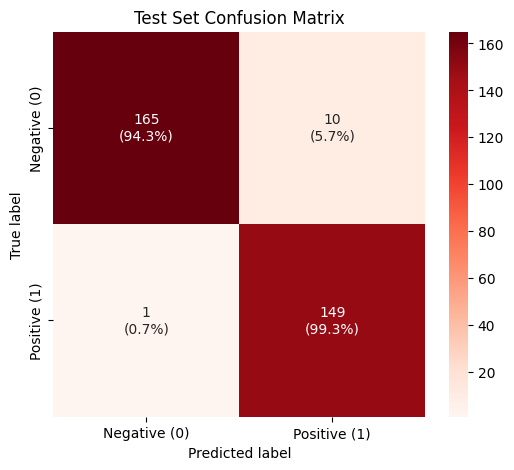

In [18]:
def plot_confusion_matrix_counts_percent(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100
    labels = ['Negative (0)', 'Positive (1)']

    annot = [[f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)" for j in range(cm.shape[1])] for i in range(cm.shape[0])]
    
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=annot, fmt='', cmap='Reds',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(title)
    plt.show()

plot_confusion_matrix_counts_percent(test_labels, test_preds, title="Test Set Confusion Matrix")



# Test cases
The trained mBERT model is evaluated on handcrafted test sentences. These sentences cover various bias patterns and scenarios, allowing inspection of the model's behavior beyond the standard test set.


## Load trained model
The model and tokenizer are loaded from the saved output directory and set to evaluation mode. This ensures that inference is performed without gradient updates.


In [19]:
model_path = "./model_output"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [20]:
# shorten text helper function
def shorten(text, max_len=40):
    if len(text) <= max_len:
        return text
    return text[:max_len-3] + "..."

## Handcrafted Test Sentences

A set of EN-DE sentence pairs is defined. Each pair is labeled as:  
- 0 = neutral (no gender bias)  
- 1 = biased (translation contains gender bias)  

The test cases include neutral sentences, neutral sentences with gendered subjects, stereotypically biased sentences, gender-fair language (GFL) examples, and job posting examples.

In [21]:
test_cases = [
    # neutral
    ("Today the weather is beautiful", "Heute ist das Wetter schön", 0), 
    ("I like this guy.", "Ich mag diesen Kerl.", 0),
    ("How are you?", "Wie geht es dir?", 0),
    ("BERT is a transformers model pretrained on a large corpus of multilingual data in a self-supervised fashion.","BERT ist ein Transformer-Modell, das auf selbstüberwachte Weise auf einem großen Korpus mehrsprachiger Daten vorab trainiert wird.",0),
    ("Knowledge is love and light and vision.","Wissen ist Liebe und Licht und Vision.",0),

    # neutral with gendered subjects
    ("My mother is an engineer.", "Meine Mutter ist Ingenieurin.", 0),
    ("Is this boy a good artist?", "Ist dieser Junge ein guter Künstler?", 0),
    ("I am living with my sister, who is also my best friend", "Ich lebe mit meiner Schwester, die auch meine beste Freundin ist", 0),
    ("My father was an excellent cook.", "Mein Vater war ein ausgezeichneter Koch.", 0),
    ("The girls went hiking.", "Die Mädchen gingen wandern.", 0),


    # biased
    ("Do you like our maths teacher?", "Mögen Sie unsere Mathelehrerin?", 1),
    ("The doctor was late to work today.", "Der Arzt kam heute zu spät zur Arbeit.", 1),
    ("Tomorrow the students are leaving for a class trip.", "Morgen gehen die Studenten zu einer Klassenfahrt.", 1),
    ("This nurse does not work hard.", "Diese Krankenschwester arbeitet nicht hart.", 1),
    ("Athletes earn a lot of money.", "Sportler verdienen viel Geld.", 1),

    # test GFL
    ("Engineers are kind and hard-working", "Ingenieur*innen sind lieb und fleißig", 0),
    ("Engineers are kind and hard-working", "Ingenieure und Ingenieurinnen sind lieb und fleißig", 0),
    ("Teachers are kind and hard-working", "Lehrende sind lieb und fleißig", 0),
    ("Teachers are kind and hard-working", "Lehrer:innen sind lieb und fleißig", 0),
    ("Teachers are kind and hard-working", "Lehrerinnen und Lehrer sind lieb und fleißig", 0),
    ("Teachers are kind and hard-working", "Lehrer sind lieb und fleißig", 1),
    ("Teachers are kind and hard-working", "Lehrerinnen sind lieb und fleißig", 1),

    # job posting morgan stanley
    ("We’re seeking someone to join our team Office 365 squads to lead the design, development, and integration of Gen AI apps and integration using Microsoft Copilot Studio.","Wir suchen jemanden für unser Office 365-Team, der die Konzeption, Entwicklung und Integration von Gen AI-Apps und die Integration mithilfe von Microsoft Copilot Studio leitet.",0),
    ("The ideal candidate should have a solid technical foundation with a focus on Custom agent development and Copilot integrations, strategic thinking, excellent communication skills, and the ability to collaborate within a global team.", "Der ideale Kandidat sollte über solide technische Grundlagen mit Schwerpunkt auf der Entwicklung kundenspezifischer Agenten und Copilot-Integrationen, strategisches Denken, ausgezeichnete Kommunikationsfähigkeiten und die Fähigkeit zur Zusammenarbeit in einem globalen Team verfügen.", 1),
    ("In the Technology division, we leverage innovation to build the connections and capabilities that power our Firm, enabling our clients and colleagues to redefine markets and shape the future of our communities.", "Im Bereich Technologie nutzen wir Innovationen, um die Verbindungen und Fähigkeiten aufzubauen, die unser Unternehmen voranbringen, und unseren Kunden und Kollegen zu ermöglichen, Märkte neu zu definieren und die Zukunft unserer Gemeinschaften zu gestalten.",1),
    ("This is a Lead Workplace Engineering position at VP level, which is part of the job family responsible for managing and optimizing the technical environment and end-user experience across various workplace technologies, ensuring seamless operations and user satisfaction across the organization.","Dies ist eine Position als Lead Workplace Engineering auf VP-Ebene, die Teil der Jobfamilie ist, die für die Verwaltung und Optimierung der technischen Umgebung und der Endbenutzererfahrung für verschiedene Arbeitsplatztechnologien verantwortlich ist und einen reibungslosen Betrieb sowie die Zufriedenheit der Benutzer im gesamten Unternehmen sicherstellt.",1),
]


## Prepare Dataset

The handcrafted sentences are converted into a `BiasDataset` instance. This allows tokenization and structured input to the model for inference.

In [22]:
# convert list of test cases into a dataframe
test_df = pd.DataFrame(test_cases, columns=["english", "german", "label"])

# create BiasDataset instance from dataframe
test_dataset = BiasDataset(test_df, tokenizer)

## Run Inference on Each Test Case

Each handcrafted sentence is passed through mBERT. Predictions, probabilities, and correctness indicators are collected for further analysis.

In [23]:
results = []

for i in range(len(test_dataset)):
    item = test_dataset[i]
    
    # prepare inputs for model, add batch dimension and move to device
    inputs = {key: val.unsqueeze(0).to(device) for key, val in item.items() if key != "labels"}
    
    # run model in evaluation mode without gradients
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred_label = torch.argmax(logits, dim=1).item()
        prob = torch.softmax(logits, dim=1)[0].cpu().numpy()
    
    # collect results
    results.append({
        "english": test_df.iloc[i]["english"],
        "german": test_df.iloc[i]["german"],
        "true_label": test_df.iloc[i]["label"],
        "predicted_label": pred_label,
        "neutral_prob": prob[0],
        "biased_prob": prob[1],
        "correct": test_df.iloc[i]["label"] == pred_label
    })


## Display Results
Results are summarized in a table showing English and German texts, true and predicted labels, probabilities for each class, and correctness. Overall model accuracy on the handcrafted test cases is reported.

In [24]:
results_df = pd.DataFrame(results)

print("\nBias detection test results:")
display(results_df)

accuracy = results_df["correct"].mean()
print(f"\nModel accuracy on test cases: {accuracy:.1%}")



Bias detection test results:


,english,german,true_label,predicted_label,neutral_prob,biased_prob,correct
0,Today the weather is beautiful,Heute ist das Wetter schön,0,0,0.999575,0.000425,True
1,I like this guy.,Ich mag diesen Kerl.,0,0,0.999731,0.000269,True
2,How are you?,Wie geht es dir?,0,0,0.999805,0.000195,True
3,BERT is a transformers model pretrained on a large corpus of multilingual data in a self-supervised fashion.,"BERT ist ein Transformer-Modell, das auf selbstüberwachte Weise auf einem großen Korpus mehrsprachiger Daten vorab trainiert wird.",0,0,0.688832,0.311168,True
4,Knowledge is love and light and vision.,Wissen ist Liebe und Licht und Vision.,0,0,0.999234,0.000766,True
5,My mother is an engineer.,Meine Mutter ist Ingenieurin.,0,1,0.441243,0.558757,False
6,Is this boy a good artist?,Ist dieser Junge ein guter Künstler?,0,0,0.622386,0.377614,True
7,"I am living with my sister, who is also my best friend","Ich lebe mit meiner Schwester, die auch meine beste Freundin ist",0,0,0.998843,0.001157,True
8,My father was an excellent cook.,Mein Vater war ein ausgezeichneter Koch.,0,0,0.907980,0.092020,True
9,The girls went hiking.,Die Mädchen gingen wandern.,0,0,0.998616,0.001384,True



Model accuracy on test cases: 84.6%
